# CFPB Exploratory Data Analysis

## 1. Importing packages and setting up the DataFrame

In [1]:
#import packages
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
from nltk.probability import FreqDist
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
from nltk.corpus import stopwords 
import seaborn as sns
import matplotlib.pyplot as plt
import re

pyLDAvis.enable_notebook()

import pandas as pd
from sodapy import Socrata
import numpy as np
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.consumerfinance.gov", None)

In [29]:
pd.set_option("display.max_colwidth", 10000)

In [2]:
# get the dataframe from the API
results = client.get("s6ew-h6mp", limit= 1000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [3]:
# let's drop all the rows without narratives
df = results_df[results_df.complaint_what_happened.notnull()]
print(df.shape)
df = df.reset_index(drop=True)
# we're now working with 435368 observations
# let's reset the index to make future manipulation easier

(435368, 18)


### Some initial visualizations

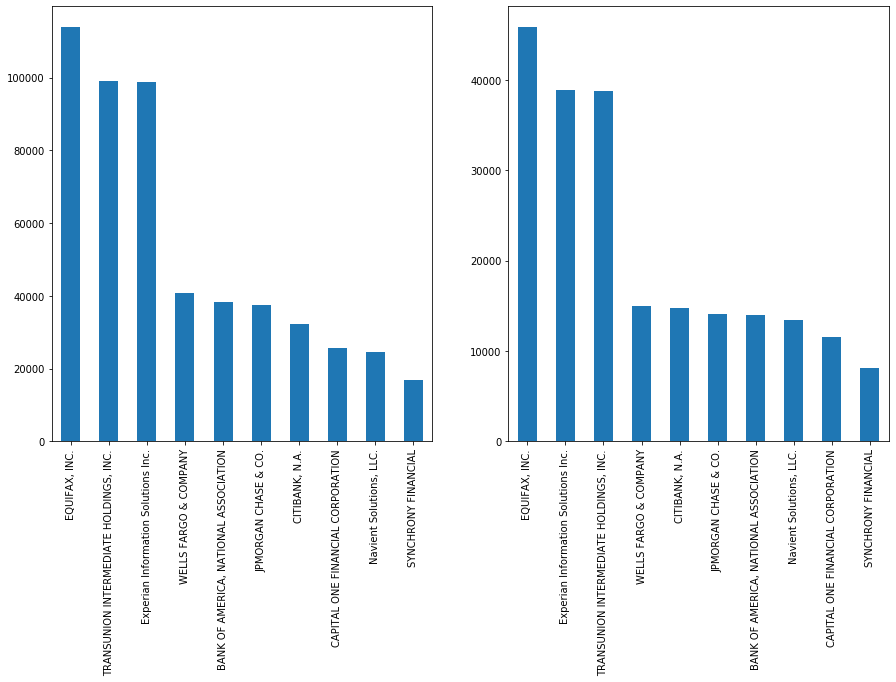

In [13]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
company_counts = results_df['company'].value_counts()
company_counts[:10].plot(kind = 'bar')
plt.subplot(1,2,2)
company_counts_narratives_only = df['company'].value_counts()
company_counts_narratives_only[:10].plot(kind = 'bar')

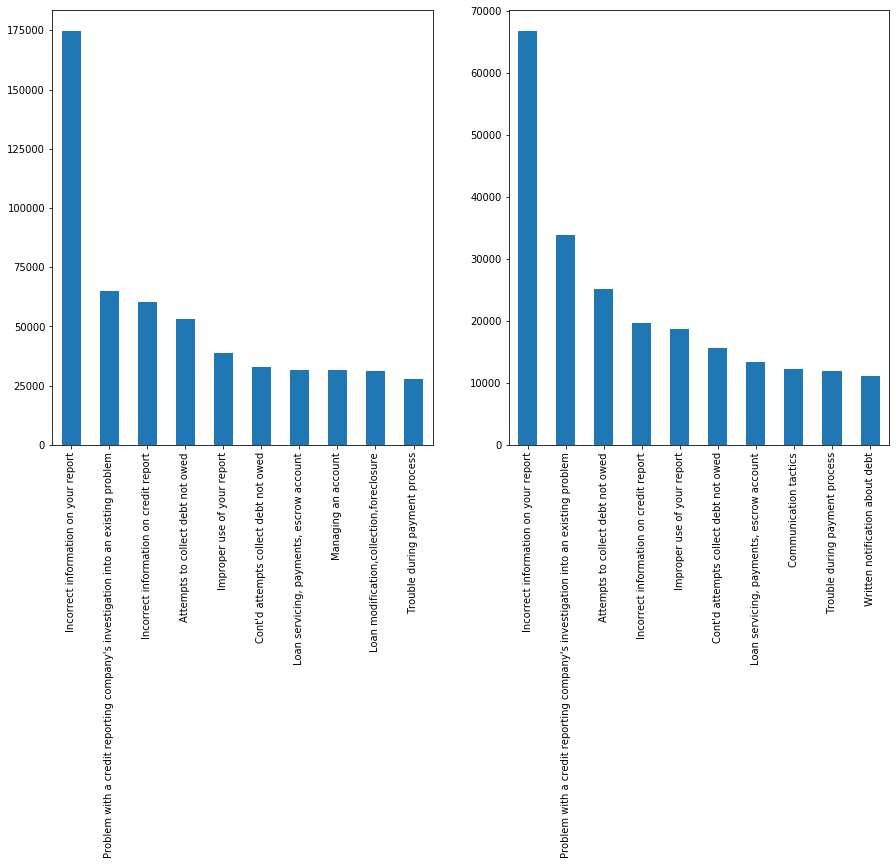

In [15]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
issue_counts = results_df['issue'].value_counts()
issue_counts[:10].plot(kind = 'bar')
plt.subplot(1,2,2)
issue_counts = df['issue'].value_counts()
issue_counts[:10].plot(kind = 'bar')

These initial visualizations show us that subsetting the full dataframe to one that only keeps rows with narratives does not change the overall patterns in the data: the top 10 companies with the most complaints are the more or less the same despite the ordering being slightly different, and the same can be said about the issues.

### Wordclouds can also be informative

In [31]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",collocations = False).generate(df['complaint_what_happened'].to_string())

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

KeyboardInterrupt: 

## 2. Preprocessing the narratives

Let's start by getting rid of all those pesky XXXX

They represent dates, or confidential information that we do not have access to, so I am not bothered about information loss

I then create another function that separates punction from the words and then filters the punctuation out (is the punctuation was attached to a word then that word would get filtered out as well, which would cause information loss)

Additionally, all words that are not composed of letters in the alphabet and are present in NLTK's stopword list are filtered out as well.

Finally remaining words are lemmatized

In [16]:
def removeX(t):
    '''
    takes in a string and returns same string with Xs removed
    '''
    t = re.sub('XXXX', '', t)
    t = re.sub('XX/XX', "", t)
    t = re.sub('XX/XX/', "", t)
    t = re.sub('XXX', "", t)
    t = re.sub('XX', "", t)
    return t

df.complaint_what_happened = df.complaint_what_happened.apply(removeX)

/Users/gabgilling/anaconda3/envs/QMSS/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
def preprocess(series):
    '''
    takes in a pandas series with strings in rows and performs basic preprocessing
    import stopwords from NLTK
    returns a pandas series with processed rows AS STRINGS
    
    '''
    stop = set(stopwords.words('english'))
    from nltk.stem import WordNetLemmatizer
    lemma = WordNetLemmatizer()
    
    series = series.apply(lambda x: ''.join([word.lower() for word in x]))
    series = series.apply(lambda x: re.sub(r"[.,!?;]", '', x))
    series = series.apply(lambda x : [word for word in x.split() if word.isalpha() and word not in stop])
#     series = series.apply(lambda x: ' '.join(x).apply(removeX))
    
    series = series.apply(lambda x: [lemma.lemmatize(word) for word in x])
    
    
    return series

In [18]:
# create a new column in the dataframe with the preprocessed narratives
df['processed'] = preprocess(df.complaint_what_happened)

/Users/gabgilling/anaconda3/envs/QMSS/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now that we've done some initial preprocessing, let's filter out some more words.

Based on some earlier modeling done with this dataframe, I concluded that verbs and proper nouns aren't really informative, so I filter them out.

In [22]:
def filter_by_pos(series):
    '''
    takes in a pandas series with strings in rows and filters words by part-of-speech filtering
    all verbs and proper nouns are removed from this model
    '''
    from nltk import sent_tokenize, word_tokenize, pos_tag
    
    pos_filt = ['VB', 'VBD', 'NNP', 'NNPS']
    series = series.apply(lambda x: ' '.join(x))
    tokenized = series.apply(lambda x: word_tokenize(x))
    temp = tokenized.apply(lambda x: [word for (word, pos) in pos_tag(x) if pos not in pos_filt])
    
#     temp = [word for (word, pos) in pos_tag(tokenized) if not is_verb(pos)]
    #     temp = series.apply(lambda x: [word for word in word_tokenize(x) if pos_tag(word) != 'VB'])
#     temp = series.apply(lambda x: word for word in x if pos_tag(toke))
    
    return temp

In [24]:
# let's update our processed narratives
texts = filter_by_pos(df.processed)

## 3. The LDA Model

In [38]:
dfs = df.sample(200000)

In [39]:
texts = dfs.processed

In [41]:
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
ldamodel = LdaModel(corpus=corpus, id2word=id2word, num_topics=12)

In [43]:
from operator import itemgetter
topics = [max(x,key=itemgetter(1))[0] for x in ldamodel[corpus]]
dfs['Topics'] = topics

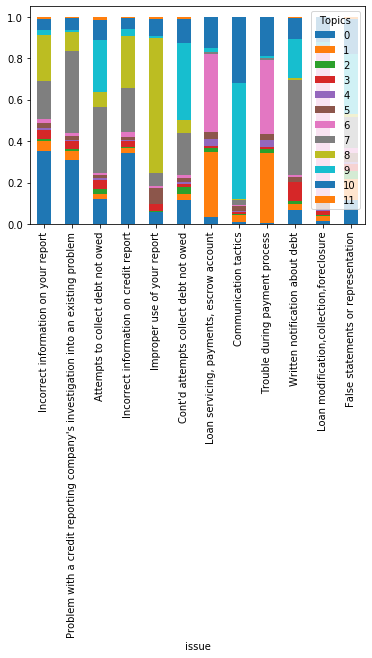

In [46]:
issues_considered = list(dfs['issue'].value_counts()[0:12].index)
newdf = dfs[dfs['issue'].isin(issues_considered)]
ct = pd.crosstab(newdf['issue'],dfs['Topics'])
ctp = ct.apply(lambda x: x/x.sum(), axis = 1)
ctp.loc[list(newdf['issue'].value_counts().index)].plot.bar(stacked = True)